# DS3000 Final Project : Recipe Review Predictor 
### Group 1: Sarah Lang, Allison Li, Jasmine Wong, David Zambrano

In [1]:
# import necessary libraries
import ast
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import math
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_theme()

# Phase 1: Reading in the Data

## Import and clean data

In [56]:
# import raw recipes into df
raw_recipes = pd.read_csv('RAW_recipes.csv')
raw_recipes.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [4]:
# check for duplicates; found none
raw_recipes = raw_recipes.drop_duplicates(keep = False)
raw_recipes.shape

(231637, 12)

Below we selected the necessary columns we would need for data analysis from `raw_recipes` and created a new dataframe called `clean_recipes`.

In [5]:
# filter out unnecessary columns
clean_recipes = raw_recipes[['id', 'name', 'minutes', 'n_steps', 'steps','n_ingredients',
                              'ingredients','nutrition']]
clean_recipes.head()

,id,name,minutes,n_steps,steps,n_ingredients,ingredients,nutrition
0,137739,arriba baked winter squash mexican style,55,11,"['make a choice and proceed with recipe', 'dep...",7,"['winter squash', 'mexican seasoning', 'mixed ...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]"
1,31490,a bit different breakfast pizza,30,9,"['preheat oven to 425 degrees f', 'press dough...",6,"['prepared pizza crust', 'sausage patty', 'egg...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]"
2,112140,all in the kitchen chili,130,6,"['brown ground beef in large pot', 'add choppe...",13,"['ground beef', 'yellow onions', 'diced tomato...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]"
3,59389,alouette potatoes,45,11,['place potatoes in a large pot of lightly sal...,11,"['spreadable cheese with garlic and herbs', 'n...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]"
4,44061,amish tomato ketchup for canning,190,5,['mix all ingredients& boil for 2 1 / 2 hours ...,8,"['tomato juice', 'apple cider vinegar', 'sugar...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]"


## Compute average ratings

Here we imported the `raw_interactions` dataset which gives us information on how users rated different recipes. We used this dataset to calculate the average rating for each recipe by aggregating all individual scores and grouping by the `recipe_id` variable, eventually giving us the dataframe `ratings`.

In [6]:
# import raw_interactions dataset to dataframe
raw_interactions = pd.read_csv('RAW_interactions.csv')
raw_interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [7]:
# drop unnecessary columns
raw_interactions = raw_interactions.drop(['date', 'review', 'user_id'], axis = 1)
raw_interactions.head()

,recipe_id,rating
0,40893,4
1,40893,5
2,44394,4
3,85009,5
4,85009,5


In [8]:
# groupby recipe_id and aggregate the mean ratings
ratings = raw_interactions.groupby('recipe_id', as_index = False)['rating'].mean()
ratings = ratings.rename(columns = {'recipe_id': 'id', 'rating' : 'avg_rating'})

In [9]:
print(ratings.head())

   id  avg_rating
0  38    4.250000
1  39    3.000000
2  40    4.333333
3  41    4.500000
4  43    1.000000


We then merged the average ratings data with the `clean_recipes` dataset.

There were a number of recipes that took an unreasonable amount of time to cook, so we chose to eliminate these outliers.

In [10]:
# add average ratings to each recipe
clean_recipes = clean_recipes.merge(ratings, on = 'id')

In [11]:
# only include recipes that can be completed within 5 hours
clean_recipes = clean_recipes.loc[(clean_recipes['minutes'] <= 300)]
clean_recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221667 entries, 0 to 231636
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             221667 non-null  int64  
 1   name           221666 non-null  object 
 2   minutes        221667 non-null  int64  
 3   n_steps        221667 non-null  int64  
 4   steps          221667 non-null  object 
 5   n_ingredients  221667 non-null  int64  
 6   ingredients    221667 non-null  object 
 7   nutrition      221667 non-null  object 
 8   avg_rating     221667 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 16.9+ MB


In [12]:
print(clean_recipes.head())

       id                                        name  minutes  n_steps  \
0  137739  arriba   baked winter squash mexican style       55       11   
1   31490            a bit different  breakfast pizza       30        9   
2  112140                   all in the kitchen  chili      130        6   
3   59389                          alouette  potatoes       45       11   
4   44061          amish  tomato ketchup  for canning      190        5   

                                               steps  n_ingredients  \
0  ['make a choice and proceed with recipe', 'dep...              7   
1  ['preheat oven to 425 degrees f', 'press dough...              6   
2  ['brown ground beef in large pot', 'add choppe...             13   
3  ['place potatoes in a large pot of lightly sal...             11   
4  ['mix all ingredients& boil for 2 1 / 2 hours ...              8   

                                         ingredients  \
0  ['winter squash', 'mexican seasoning', 'mixed ...   
1  ['prepa

In [13]:
clean_recipes.shape

(221667, 9)

In [14]:
# drop rows with na values
clean_recipes.dropna()
clean_recipes.shape

(221667, 9)

## Extract nutrition information

Here we split up the `nutrition` column into separate variables regarding nutrition information.

The nutrition information included the calorie count, total fat, sugar, sodium, protein, saturated fat, and carbohydrates.

In [15]:
def str_to_lst(string):
    '''
    str_to_lst turns a string in format '3, 4, 5' to a list ['3', '4', '5']
    
    parameters: 
    string(str) : string of interest
    
    returns:
    string(lst) : mutated string as a list
    '''
    string = string.split(', ')
    
    return string

In [16]:
# initialize a nutrition dataframe
nutrition = pd.DataFrame(clean_recipes['nutrition'])
print(nutrition.head())

                                    nutrition
0       [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]
1   [173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]
2  [269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]
3   [368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]
4   [352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]


In [17]:
# remove brackets and turn to list
nutrition['nutrition'] = nutrition['nutrition'].apply(lambda x: x.replace('[', ''))
nutrition['nutrition'] = nutrition['nutrition'].apply(lambda x: x.replace(']', ''))
nutrition['nutrition'] = nutrition['nutrition'].apply(lambda x: str_to_lst(x))
print(nutrition.head())

                                    nutrition
0       [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]
1   [173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]
2  [269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]
3   [368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]
4   [352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]


In [18]:
# rename columns and print out the new dataframe
nutrition = pd.DataFrame(nutrition['nutrition'].to_list(), columns = ['calories', 'total_fat', 'sugar', 'sodium',
                                                        'protein', 'saturated_fat','carbs'])
print(nutrition.head())

  calories total_fat  sugar sodium protein saturated_fat carbs
0     51.5       0.0   13.0    0.0     2.0           0.0   4.0
1    173.4      18.0    0.0   17.0    22.0          35.0   1.0
2    269.8      22.0   32.0   48.0    39.0          27.0   5.0
3    368.1      17.0   10.0    2.0    14.0           8.0  20.0
4    352.9       1.0  337.0   23.0     3.0           0.0  28.0


In [19]:
# create a row_num column to assist with merging
nutrition['row_num'] = np.arange(len(nutrition))
print(nutrition.head())

  calories total_fat  sugar sodium protein saturated_fat carbs  row_num
0     51.5       0.0   13.0    0.0     2.0           0.0   4.0        0
1    173.4      18.0    0.0   17.0    22.0          35.0   1.0        1
2    269.8      22.0   32.0   48.0    39.0          27.0   5.0        2
3    368.1      17.0   10.0    2.0    14.0           8.0  20.0        3
4    352.9       1.0  337.0   23.0     3.0           0.0  28.0        4


In [20]:
# add row_number to recipes dataframe and merge with nutrition information
clean_recipes['row_num'] = np.arange(len(clean_recipes))
clean_recipes = nutrition.merge(clean_recipes, left_on = 'row_num', right_on = 'row_num')

In [21]:
#drop nutrition and row number columns
clean_recipes.drop(['row_num', 'nutrition'], axis = 1).head(5)

,calories,total_fat,sugar,sodium,protein,saturated_fat,carbs,id,name,minutes,n_steps,steps,n_ingredients,ingredients,avg_rating
0,51.5,0.0,13.0,0.0,2.0,0.0,4.0,137739,arriba baked winter squash mexican style,55,11,"['make a choice and proceed with recipe', 'dep...",7,"['winter squash', 'mexican seasoning', 'mixed ...",5.0
1,173.4,18.0,0.0,17.0,22.0,35.0,1.0,31490,a bit different breakfast pizza,30,9,"['preheat oven to 425 degrees f', 'press dough...",6,"['prepared pizza crust', 'sausage patty', 'egg...",3.5
2,269.8,22.0,32.0,48.0,39.0,27.0,5.0,112140,all in the kitchen chili,130,6,"['brown ground beef in large pot', 'add choppe...",13,"['ground beef', 'yellow onions', 'diced tomato...",4.0
3,368.1,17.0,10.0,2.0,14.0,8.0,20.0,59389,alouette potatoes,45,11,['place potatoes in a large pot of lightly sal...,11,"['spreadable cheese with garlic and herbs', 'n...",4.5
4,352.9,1.0,337.0,23.0,3.0,0.0,28.0,44061,amish tomato ketchup for canning,190,5,['mix all ingredients& boil for 2 1 / 2 hours ...,8,"['tomato juice', 'apple cider vinegar', 'sugar...",5.0


# Phase 2: EDA and Visualizations

Text(0.5, 1.0, 'Ratings Distribution')

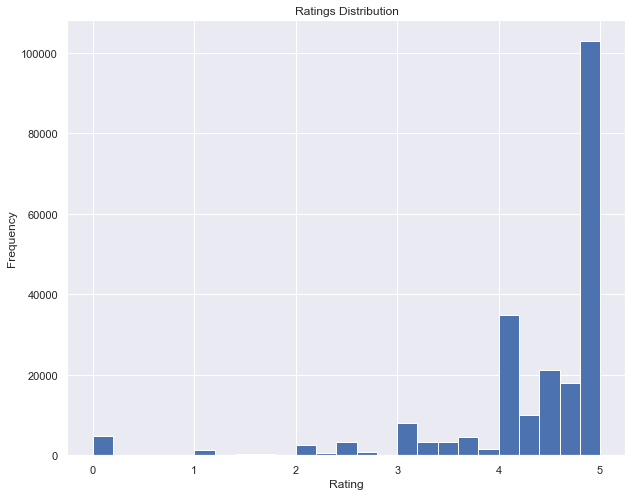

In [52]:
# a histogram of ratings distributions + describe 
clean_recipes['avg_rating'].plot(kind ='hist', x="avg_rating", figsize=(10, 8), bins=25)

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Ratings Distribution')

The histogram is skewed to the left, meaning more reviews are concentrated on the higher side. 

In [24]:
# report key statistical measures for avg rating column
rts = clean_recipes['avg_rating']
rts.describe()

count    221667.000000
mean          4.352027
std           0.985754
min           0.000000
25%           4.000000
50%           4.717949
75%           5.000000
max           5.000000
Name: avg_rating, dtype: float64

The average rating for all recipes is 4.35, which means the data we have are pretty well liked by people who tried the recipes. We can tell from both the mean and the median (4.72) that the data is skewed to the left as well.

Text(0.5, 0, 'Number of Ingredients')

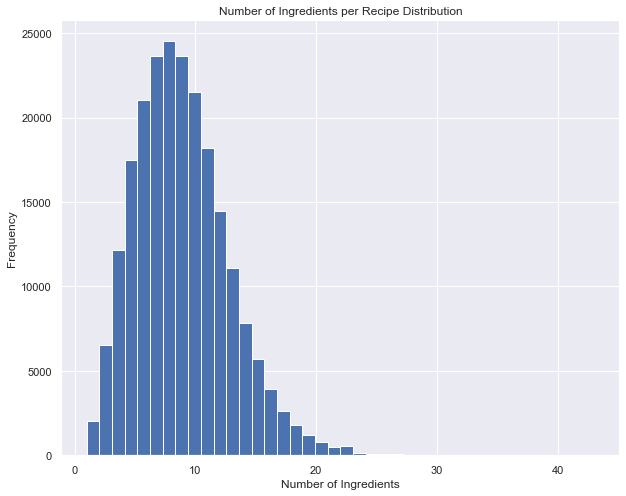

In [53]:
# a histogram about number of ingredients column
clean_recipes['n_ingredients'].plot(kind ='hist', x="n_ingredients", figsize=(10, 8), bins=40)
plt.title('Number of Ingredients per Recipe Distribution')
plt.xlabel('Number of Ingredients')

The plot above is skewed to the right, signaling there are more recipes with less ingredients.

In [26]:
# report key statisticals measures for n_ingredients column
ings = clean_recipes['n_ingredients']
ings.describe()

count    221667.000000
mean          9.030144
std           3.714422
min           1.000000
25%           6.000000
50%           9.000000
75%          11.000000
max          43.000000
Name: n_ingredients, dtype: float64

The average number of ingredients used in all the recipes is 9. This is the same value as the median of the dataset.

Text(0.5, 1.0, 'Cooking Time Distribution')

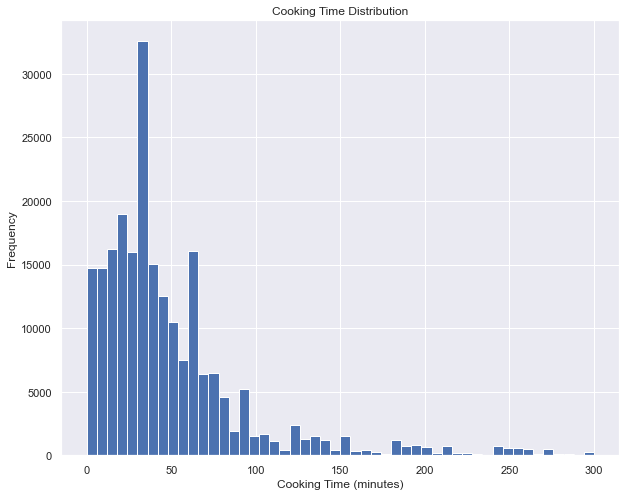

In [54]:
# a histogram about number of minutes cooking time column
clean_recipes['minutes'].plot(kind ='hist', x="minutes", figsize=(10, 8), bins=50)
plt.xlabel('Cooking Time (minutes)')
plt.title('Cooking Time Distribution')

The chart is right skewed, meaning that most recipes take less than 1 or 2 hours to complete

In [28]:
# report key statistical measures for avg rating column
mins = clean_recipes['minutes']
mins.describe()

count    221667.000000
mean         49.176012
std          46.586803
min           0.000000
25%          20.000000
50%          35.000000
75%          60.000000
max         300.000000
Name: minutes, dtype: float64

The average time to complete a recipe is 49.176 minutes. The standard deviation is pretty big because of some recipes that takes a really long time to make.

# Phase 3: Model Building

## Splitting the Data into Train/Test

In [29]:
X   = clean_recipes[['n_ingredients', 'n_steps', 'minutes', 'calories', 'total_fat', 
                     'sugar', 'sodium', 'saturated_fat', 'carbs']] #get the input features
y   = clean_recipes['avg_rating']              #get the target

In [31]:
#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 7,
                                        ) 

## Model 1: KNN Regression Model

In [32]:
# import necessary libraries for knn regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [33]:
# create a list of k values to test for preliminary understanding of parameter k
k_lst = [*range(5, 600, 25)]
k_lst

[5,
 30,
 55,
 80,
 105,
 130,
 155,
 180,
 205,
 230,
 255,
 280,
 305,
 330,
 355,
 380,
 405,
 430,
 455,
 480,
 505,
 530,
 555,
 580]

In [34]:
# initialize empty dictionary to store results
predictions = {}

# iterate through all of the random k values
for k in k_lst: 
    # initialize the classifier and set the number of neighbors as k
    knn_reg = KNeighborsRegressor(n_neighbors = k)
    # fit the model and predict ratings
    knn_reg.fit(X_train, y_train)
    y_pred = knn_reg.predict(X_test)
    # store predictions and mse scores in dictionary
    predictions[k] = mean_squared_error(y_test, y_pred)

In [35]:
# inspect predictions dict
predictions

{5: 1.1444823204647439,
 30: 0.9920878778138371,
 55: 0.9794958653794114,
 80: 0.9744672823358334,
 105: 0.9713257725235833,
 130: 0.9699623470168528,
 155: 0.9689087233247548,
 180: 0.9682789171738468,
 205: 0.9681394130166964,
 230: 0.9676964970792298,
 255: 0.9671423407849596,
 280: 0.9669621798379352,
 305: 0.9667557928991447,
 330: 0.9665399411237545,
 355: 0.9663380952383561,
 380: 0.9663194046700795,
 405: 0.9660790099875474,
 430: 0.9659946675476484,
 455: 0.9658807175610385,
 480: 0.9657604296686063,
 505: 0.965590382850074,
 530: 0.9656513964683249,
 555: 0.9655814414516621,
 580: 0.96560359094756}

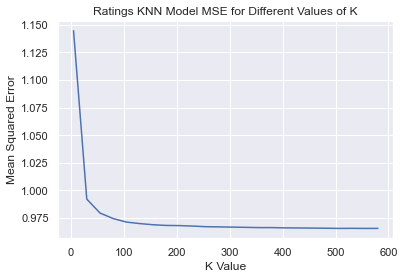

In [36]:
# plot predictions and mse to gauge hyperparameter tuning range
import seaborn as sns
sns.lineplot(x=predictions.keys(), y=predictions.values())
plt.xlabel("K Value")
plt.ylabel('Mean Squared Error')
plt.title('Ratings KNN Model MSE for Different Values of K')
plt.show()

### The linegraph above gives us a ballpark of the diminishing effectiveness of larger k values.

In [37]:
# initiate gridsearch based on the range of interest identified above
params = {'n_neighbors': np.arange(90,160)}

knn = KNeighborsRegressor()
knn_model = GridSearchCV(knn, params, cv=5)
knn_model.fit(X_train,y_train)

# reveal best k parameter
knn_model.best_params_

{'n_neighbors': 159}

## Model 2: Decision Tree Model

In [38]:
# import necessary libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [39]:
# initialize and fit data to decision tree
dt = DecisionTreeRegressor(random_state=7, max_depth = 20)
dt.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=20, random_state=7)

In [40]:
#predict the labels for the test set
y_pred_dt   = dt.predict(X_test)
print('The predicted rating is: {}'.format(y_pred_dt))


The predicted rating is: [4.11463633 3.         4.42248887 ... 4.51859147 5.         4.38268464]


In [41]:
# Evaluate the Predictions
dec_tree_mse = mean_squared_error(y_test, y_pred_dt)
print('The mse of the model is: {}'.format(dec_tree_mse))


The mse of the model is: 1.3754056590217207


## Model 3: Random Forest Regressor

In [42]:
# initialize random forest regressor and fit data to model
rf = RandomForestRegressor(random_state = 0, n_estimators = 100)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [43]:
# use model to predict test data
y_pred = rf.predict(X_test)

# calc mse for predictions vs actual
mse = mean_squared_error(y_test, y_pred)
print('The mean squared error for the random forest regressor is:', mse)

The mean squared error for the random forest regressor is: 1.009546625342863


In [44]:
#Hyperparameter tuning
n_estimator_arr = [200, 175, 150] #an array that stores 3 n_estimators different from the default value
mse_arr = [] #an array that stores 3 mean squared errors of the 3 models tried with the 3 n_estimators above


In [45]:
#build 3 new models and predict y 3 times using the 3 n_estimators and print out their respective mse in an array
for item in n_estimator_arr:
    new_rf = RandomForestRegressor(random_state=7, n_estimators = item)
    new_rf.fit(X_train, y_train)
    y_pred   = new_rf.predict(X_test)
    new_mse = mean_squared_error(y_test, y_pred)
    mse_arr.append(new_mse)


In [46]:
print(mse_arr) #print the three mean squared errors

[1.0033235131108325, 1.0037585835632858, 1.0050007009034847]


In [ ]:
# initiate a gridsearch for hyperparameter tuning, and find the best n_estimartor to use in the model.
params = {'n_estimators': np.arange(225, 275)}
rfr = RandomForestRegressor()
rfr_grid = GridSearchCV(estimator = rfr, param_grid = params, return_train_score = True) 
rfr_grid.fit(X_train, y_train)

print(rfr_grid.best_params_)
print(rfr_grid.best_score_)

## Feature importance

In [50]:
#Get an array of importance measures of all features using the best RandomForestRegressor model
rf.feature_importances_

array([0.08655053, 0.09754696, 0.09280164, 0.18411648, 0.09327929,
       0.13818736, 0.11421365, 0.11258019, 0.08072388])

Text(0.5, 1.0, 'Feature Importance of Model')

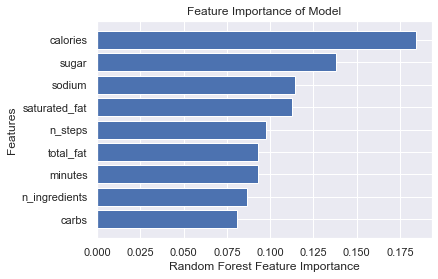

In [51]:
#Plot the feature importances from most important to least
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.ylabel("Features")
plt.title('Feature Importance of Model')

Text(0, 0.5, 'MSE')

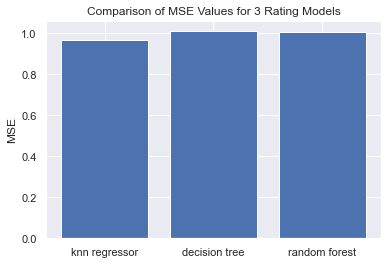

In [58]:
best_mse = [predictions[580], mse, mse_arr[0]]
best_mse_names = ['knn regressor', 'decision tree', 'random forest']
plt.bar(best_mse_names, best_mse)
plt.title('Comparison of MSE Values for 3 Rating Models')
plt.ylabel('MSE')

In [59]:
print(best_mse)

[0.96560359094756, 1.009546625342863, 1.0033235131108325]
